# Can overconfidence be eliminated by reserving a portion of the training data to only be optimized for the distribution parameters $\sigma$ and $\alpha$, and unseen by $\mu$?
Specifically, train everything on a large portion of the training data, then forecast the mean of the unseen training data, and train the skewness and variance on that portion.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew
from sklearn import linear_model

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [6]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)

# Get data

In [7]:
zone_name = "VT"

In [8]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017QualAll.json") as f:
    all_data = json.loads(f.read())
    
data = np.transpose(np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64))
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
zones = list(all_data.keys())
print(zones)

['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']


## Vanilla Benchmark Forecast

In [9]:
# TODO: rerun this / have json / show results 
# test_start_dates = np.array(list(pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00") for month_idx in range(12)))
# train_end_dates = test_start_dates - delay_delta
# train_start_dates = list(end_date.replace(year=end_date.year - 11) for end_date in train_end_dates)
# vanilla_losses = dict()
# for zone_name in zones:
#     print("\n\nZONE:", zone_name)
#     vanilla_losses[zone_name] = []
#     for i, start_date in enumerate(train_start_dates):
#         print("testing on ", test_start_dates[i])
#         loss = vanilla_benchmark.get_lossesGEFCom(11, 31 * 24, start_date=start_date, zones=[zone_name],
#                               delay_days=delay_delta.days, plot=True)[zone_name]
#         vanilla_losses[zone_name].append(loss)
# vanilla_losses = pd.DataFrame(vanilla_losses)
# vanilla_losses["month"] = months
# vanilla_losses.to_pickle("experiments/vanilla_comp/vanilla_losses.pkl")

In [10]:
vanilla_losses = pd.read_pickle("experiments/vanilla_comp/vanilla_losses.pkl")
vanilla_losses

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,month
0,408.154829,29.233567,24.876474,23.063410,112.561256,35.736322,51.199884,54.263446,88.284008,Jan
1,443.151870,26.692837,28.173495,17.330917,124.619217,35.606366,61.938971,68.609597,94.677206,Feb
2,439.669393,31.045516,26.425418,24.951994,124.776168,39.115508,59.614972,64.665490,81.413050,Mar
3,264.144823,20.790036,14.921651,21.211305,69.097793,21.693562,43.575302,42.452532,50.955286,Apr
4,357.882407,18.163494,22.615686,19.116892,100.970034,29.510675,47.698605,50.690831,85.043369,May
5,652.780381,30.590284,49.263655,20.730293,197.475926,61.310765,83.767520,86.007503,138.058412,Jun
6,851.332136,41.347337,68.074700,23.976316,257.672027,75.398389,123.011677,100.678476,168.440029,Jul
7,685.693005,35.175272,54.367699,23.619663,204.783412,62.844280,99.541872,80.509113,123.971252,Aug
8,584.697608,26.598327,44.706890,23.609768,174.820847,50.953341,71.602025,80.941435,118.303592,Sep
9,296.427142,30.981392,21.071335,20.106964,77.189918,27.987985,42.737260,38.424980,62.007270,Oct


# Forecasting mean, variance, and skewness of Skew-Normal distribution

In [11]:
%matplotlib inline
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

## Control

Testing on month Feb
MONTH: Feb
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4929682981544843
Loss at iteration 60: -1.6354456769994632
Loss at iteration 110: -1.6531825785455396
Final loss: -1.65619273213497


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: 0.002409019
mean test z-score: -0.5015162232896553
rms test z-score: 1.279951283179686


<IPython.core.display.Javascript object>

pinball_loss: 15.158904333678715
12.532591363542412% performance relative to vanilla benchmark





Testing on month Apr
MONTH: Apr
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4905647222554947
Loss at iteration 60: -1.6362395749607501
Loss at iteration 110: -1.652429680357013
Final loss: -1.6554996337342207


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: 0.002937291
mean test z-score: -0.44177302119596745
rms test z-score: 1.8720494307874993


<IPython.core.display.Javascript object>

pinball_loss: 16.324363847296365
23.03932508866503% performance relative to vanilla benchmark





Testing on month Jun
MONTH: Jun
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4973032990297617
Loss at iteration 60: -1.6279341133717569
Loss at iteration 110: -1.6548831558798924
Final loss: -1.6585376424027074


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.002293615
mean test z-score: -0.40848281784292556
rms test z-score: 1.6031746250215317


<IPython.core.display.Javascript object>

pinball_loss: 22.860505371598183
-10.275840824239936% performance relative to vanilla benchmark





Testing on month Aug
MONTH: Aug
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4400745097178316
Loss at iteration 60: -1.6055736444580326
Loss at iteration 110: -1.62099040835966
Final loss: -1.6231916402136146


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.0071008885
mean test z-score: -0.6625873139771413
rms test z-score: 1.5279984716555584


<IPython.core.display.Javascript object>

pinball_loss: 23.083318996100925
2.2707526293986313% performance relative to vanilla benchmark





Testing on month Oct
MONTH: Oct
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4384879992306383
Loss at iteration 60: -1.5979534751799687
Loss at iteration 110: -1.6227770571441906
Final loss: -1.6268936160094838


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.0025927394
mean test z-score: -0.8238655149166475
rms test z-score: 1.9693943899808368


<IPython.core.display.Javascript object>

pinball_loss: 19.23835800852474
4.319924839014943% performance relative to vanilla benchmark





Testing on month Dec
MONTH: Dec
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4722021474696474
Loss at iteration 60: -1.579295590708755
Loss at iteration 110: -1.5994932181650212
Final loss: -1.602450332848657


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.012027052
mean test z-score: 0.9385588019536698
rms test z-score: 1.466411418098569


<IPython.core.display.Javascript object>


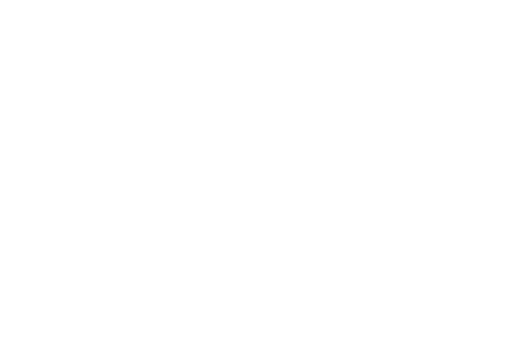

pinball_loss: 24.081461451377038
-9.180952190868519% performance relative to vanilla benchmark







In [12]:
for month_name in months[1:][::2]:
    
    month_idx = months.index(month_name)
    print("Testing on month", months[month_idx])
    test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
    test_start = np.argwhere(dates == test_start_date)[0, 0]
    test_length = 31 * 24
    
    delay_delta = pd.Timedelta(days=52)
    delay = delay_delta.days * 24
    train_end_date = test_start_date - delay_delta
    train_start_date = train_end_date.replace(year=train_end_date.year - 11)
    train_start = np.argwhere(dates == train_start_date)[0, 0]
    train_length_delta = train_end_date - train_start_date
    train_through = train_length_delta.days * 24
    pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
    pre_length = pre_length_delta.days * 24

    print("MONTH:", month_name)
    data = np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64).T

    # rescale data
    x_original = data
    mean = np.mean(data, axis=0)
    rnge = np.max(data, axis=0) - np.min(data, axis=0)
    data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
    print("data", data.shape)

    predict_through = train_through + delay + test_length
    x = data[train_start:][:predict_through]
    xt_trendy = x[:train_through]
    reg = linear_model.LinearRegression()
    t_vec = np.arange(train_through).reshape(-1, 1)
    reg.fit(t_vec, xt_trendy)
    trend_line = reg.predict(t_vec)
    xt = xt_trendy - trend_line

    # mask = torch.ones(xt.shape, dtype=torch.uint8)
    # mask[:pre_length] = 0
    num_freqs = [4, 4, 4]
    num_fourier = 4
    print("x", x.shape)
    print("xt", xt.shape)

    now = ("_".join(str(datetime.now()).split())).replace(":", ".")

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    data_name = "control_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now
    # data_name = "masked_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now

    k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=None);
    # k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

    fname = "experiments\\overconfidence\\" + data_name + f"trained{train_start}-{train_through}_"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    # ADD BACK THE TREND
    trend_line = reg.predict(np.arange(predict_through).reshape(-1, 1))
    mu_hat += trend_line

    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    print("mean test z-score:", np.mean(test_z_scores[-1]))
    print("rms test z-score:", rms(test_z_scores[-1]))

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / np.sqrt(1 + ah ** 2)
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    muh = muh + mean - (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[zone_name].iloc[month_idx]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

## Masked

In [13]:
for month_name in months[1:][::2]:
    
    month_idx = months.index(month_name)
    print("Testing on month", months[month_idx])
    test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
    test_start = np.argwhere(dates == test_start_date)[0, 0]
    test_length = 31 * 24
    
    delay_delta = pd.Timedelta(days=52)
    delay = delay_delta.days * 24
    train_end_date = test_start_date - delay_delta
    train_start_date = train_end_date.replace(year=train_end_date.year - 11)
    train_start = np.argwhere(dates == train_start_date)[0, 0]
    train_length_delta = train_end_date - train_start_date
    train_through = train_length_delta.days * 24
    pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
    pre_length = pre_length_delta.days * 24

    print("MONTH:", month_name)
    data = np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64).T

    # rescale data
    x_original = data
    mean = np.mean(data, axis=0)
    rnge = np.max(data, axis=0) - np.min(data, axis=0)
    data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
    print("data", data.shape)

    predict_through = train_through + delay + test_length
    x = data[train_start:][:predict_through]
    xt_trendy = x[:train_through]
    reg = linear_model.LinearRegression()
    t_vec = np.arange(train_through).reshape(-1, 1)
    reg.fit(t_vec, xt_trendy)
    trend_line = reg.predict(t_vec)
    xt = xt_trendy - trend_line

    mask = torch.ones(xt.shape, dtype=torch.uint8)
    mask[:pre_length] = 0
    num_freqs = [4, 4, 4]
    num_fourier = 4
    print("x", x.shape)
    print("xt", xt.shape)

    now = ("_".join(str(datetime.now()).split())).replace(":", ".")

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    # data_name = "control_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now
    data_name = "masked_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now

    # k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=None);
    k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

    fname = "experiments\\overconfidence\\" + data_name + f"trained{train_start}-{train_through}_"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    # ADD BACK THE TREND
    trend_line = reg.predict(np.arange(predict_through).reshape(-1, 1))
    mu_hat += trend_line

    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    print("mean test z-score:", np.mean(test_z_scores[-1]))
    print("rms test z-score:", rms(test_z_scores[-1]))

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / np.sqrt(1 + ah ** 2)
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    muh = muh + mean - (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[zone_name].iloc[month_idx]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

Testing on month Feb
MONTH: Feb
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.178764169114411
Loss at iteration 60: -1.543283576759393
Loss at iteration 110: -1.5577142970149618
Final loss: -1.5596466524380268


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: 0.008054631
mean test z-score: -0.6329286837695758
rms test z-score: 1.1907669336981344


<IPython.core.display.Javascript object>

pinball_loss: 16.61608215927378
4.124624301956114% performance relative to vanilla benchmark





Testing on month Apr
MONTH: Apr
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.1128856643127654
Loss at iteration 60: -1.54389330694035
Loss at iteration 110: -1.5637171206922207
Final loss: -1.5655304423286578


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.0002245877
mean test z-score: -0.4130873107356014
rms test z-score: 1.3620951847295615


<IPython.core.display.Javascript object>

pinball_loss: 14.813508719057188
30.16220175633967% performance relative to vanilla benchmark





Testing on month Jun
MONTH: Jun
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.101725524080752
Loss at iteration 60: -1.5139428493372524
Loss at iteration 110: -1.5312400309542142
Final loss: -1.534479910336756


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.0011317172
mean test z-score: -0.3350935342938363
rms test z-score: 1.1983496866216343


<IPython.core.display.Javascript object>

pinball_loss: 19.95635354620383
3.7333763483822002% performance relative to vanilla benchmark





Testing on month Aug
MONTH: Aug
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.1182441420309335
Loss at iteration 60: -1.487169381587936
Loss at iteration 110: -1.5133696695018832
Final loss: -1.5158849088117172


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.0002495788
mean test z-score: -0.8218658538653358
rms test z-score: 1.3154718299792645


<IPython.core.display.Javascript object>

pinball_loss: 23.38616720270505
0.9885658128512831% performance relative to vanilla benchmark





Testing on month Oct
MONTH: Oct
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.1290169052130201
Loss at iteration 60: -1.4856976322739153
Loss at iteration 110: -1.5066048153789011
Final loss: -1.5101091166981198


<ipython-input-13-ab81e28b7331>:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.0022928622
mean test z-score: -0.47525040167599975
rms test z-score: 1.3483395011387487


<IPython.core.display.Javascript object>

pinball_loss: 17.248266644780195
14.217447859219256% performance relative to vanilla benchmark





Testing on month Dec
MONTH: Dec
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.0959815616657445
Loss at iteration 60: -1.4527911996840532
Loss at iteration 110: -1.4732761703261852
Final loss: -1.476675240881568


<IPython.core.display.Javascript object>

actual overall mean: 0  predicted mean: -0.009793046
mean test z-score: 0.7559872876269464
rms test z-score: 1.2878488231072451


<IPython.core.display.Javascript object>

pinball_loss: 21.61397470032989
2.0061825078137696% performance relative to vanilla benchmark







# Figures

In [14]:
# for tables
for loss in losses[:6]:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perfs[:6]:
    print(np.round(rel, 1), end="%\t")

15.2	16.3	22.9	23.1	19.2	24.1	
12.5%	23.0%	-10.3%	2.3%	4.3%	-9.2%	

In [15]:
idx = 6
for z_score in z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")

0.0	-0.03	0.03	0.07	-0.06	0.08	
0.99	0.99	1.01	0.99	0.99	1.01	
0.26	0.2	0.27	0.15	0.13	0.23	
-0.5	-0.44	-0.41	-0.66	-0.82	0.94	
1.18	1.82	1.55	1.38	1.79	1.13	
-0.81	-1.1	0.25	-0.43	-1.05	-0.49	

mean of z-scores in month Feb: 0.002163449486969106 rms of z-scores: 0.9941880976447143
mean of z-scores in month Apr: -0.025590855827401133 rms of z-scores: 0.9861789195134717
mean of z-scores in month Jun: 0.03279958150272111 rms of z-scores: 1.0120527809713227
mean of z-scores in month Aug: 0.07252800095895628 rms of z-scores: 0.996391238425325
mean of z-scores in month Oct: -0.05540006094674168 rms of z-scores: 0.9885178688837315
mean of z-scores in month Dec: 0.07782229003070817 rms of z-scores: 1.0121987842825033
mean of z-scores in month Feb: -0.08694292465726369 rms of z-scores: 0.8947297048860554
mean of z-scores in month Apr: 0.010192120220820968 rms of z-scores: 0.8730757479905124
mean of z-scores in month Jun: -0.013073462721648964 rms of z-scores: 0.8870079030671562
mean of z-scores in month Aug: -0.05546714392802427 rms of z-scores: 0.8870891493387495
mean of z-scores in month Oct: -0.06510445224471079 rms of z-scores: 0.8878526144925771
mean of z-scores in month Dec: 0.0

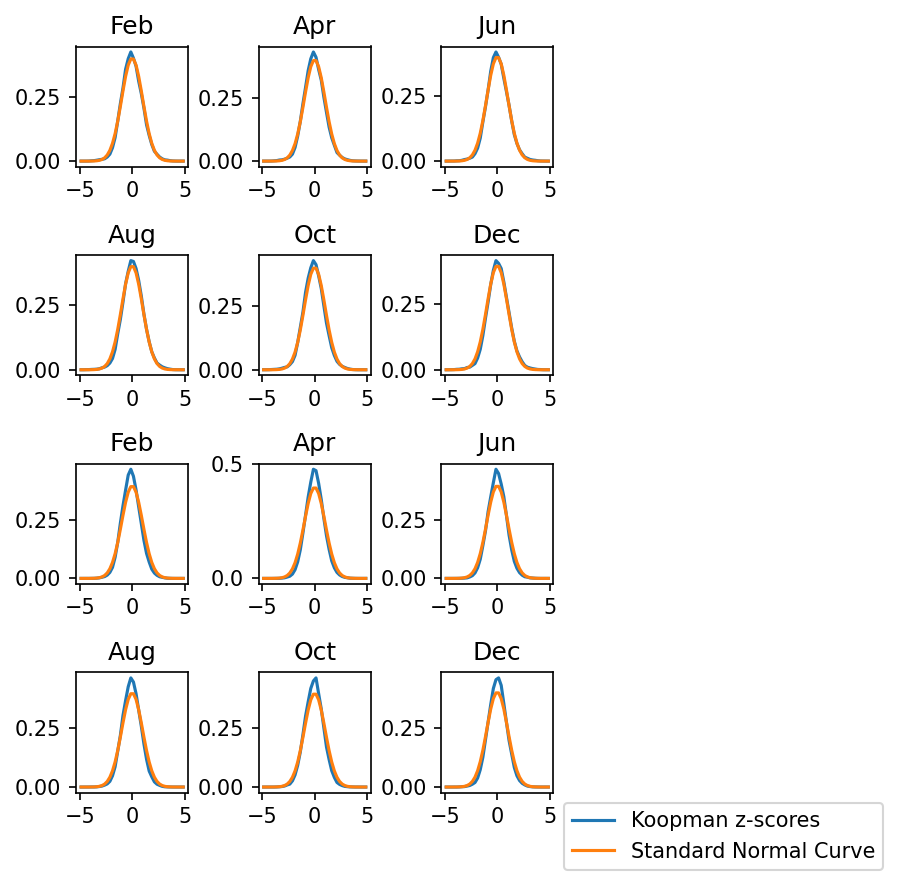

In [16]:
%matplotlib inline
z_hists = []
plt.subplots(dpi=150, figsize=(6, 6))
for i, z_score in enumerate(z_scores):
    month = (2 * i + 1) % 12
    z_hist, bin_edges = np.histogram(z_score, bins=40, range=(-5, 5), density=True)
    z_hists.append(z_hist)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
    print(f"mean of z-scores in month {months[month]}:", np.mean(z_score), "rms of z-scores:", rms(z_score))
    
    plt.subplot(4, 3, i + 1)
    plt.plot(z_axis, z_hist, label="Koopman z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(months[month])
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

mean of z-scores in month 1: -0.5015162232896553 rms of z-scores: 1.279951283179686
mean of z-scores in month 3: -0.44177302119596745 rms of z-scores: 1.8720494307874993
mean of z-scores in month 5: -0.40848281784292556 rms of z-scores: 1.6031746250215317
mean of z-scores in month 7: -0.6625873139771413 rms of z-scores: 1.5279984716555584
mean of z-scores in month 9: -0.8238655149166475 rms of z-scores: 1.9693943899808368
mean of z-scores in month 11: 0.9385588019536698 rms of z-scores: 1.466411418098569
mean of z-scores in month 1: -0.6329286837695758 rms of z-scores: 1.1907669336981344
mean of z-scores in month 3: -0.4130873107356014 rms of z-scores: 1.3620951847295615
mean of z-scores in month 5: -0.3350935342938363 rms of z-scores: 1.1983496866216343
mean of z-scores in month 7: -0.8218658538653358 rms of z-scores: 1.3154718299792645
mean of z-scores in month 9: -0.47525040167599975 rms of z-scores: 1.3483395011387487
mean of z-scores in month 11: 0.7559872876269464 rms of z-scores

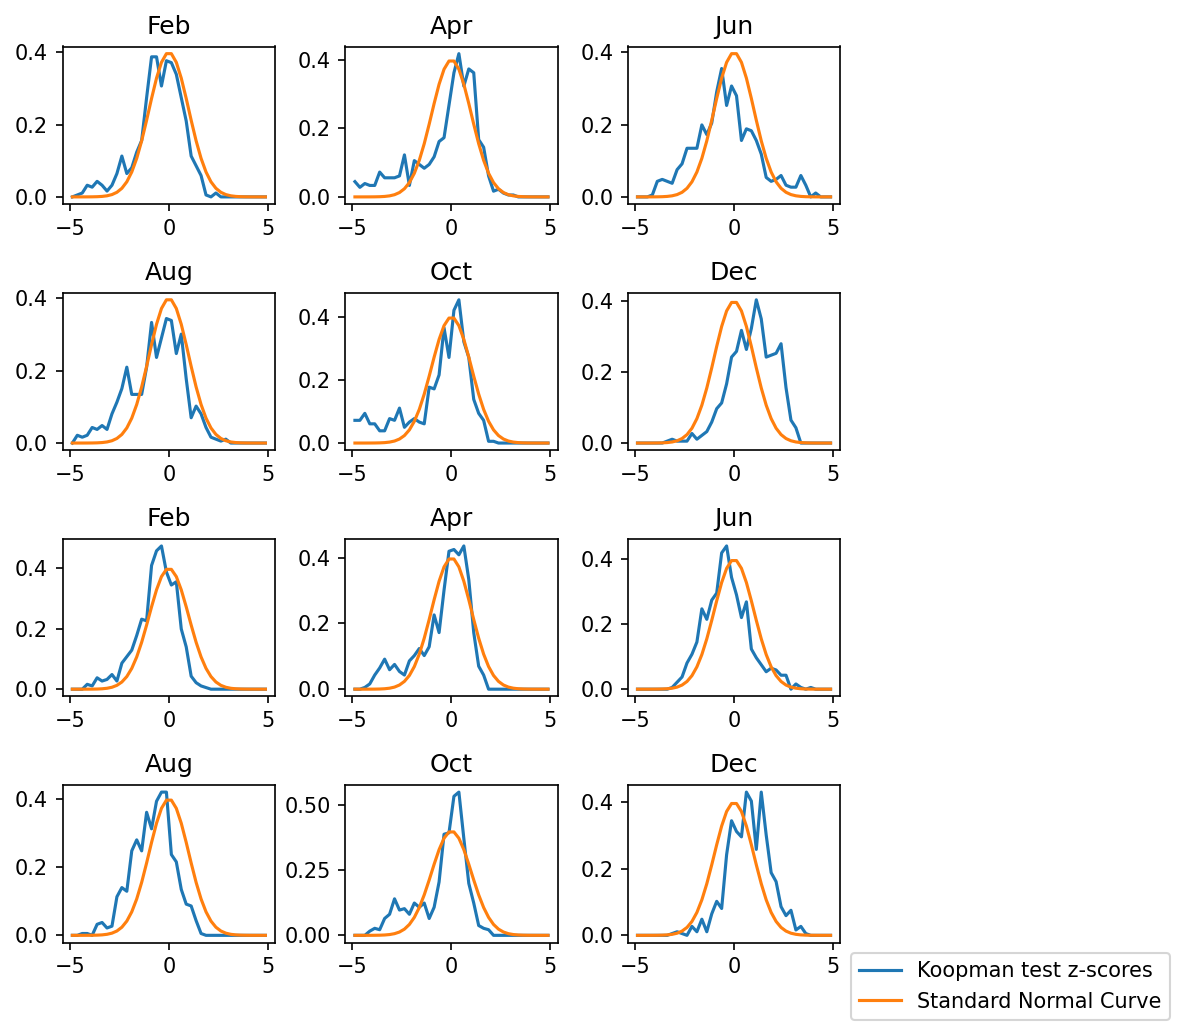

In [17]:
%matplotlib inline
test_z_hists = []
plt.subplots(dpi=150, figsize=(8, 7))
for i, z_score in enumerate(test_z_scores):
    month = (2 * i  + 1) % 12
    z_hist, bin_edges = np.histogram(z_score, bins=40, range=(-5, 5), density=True)
    test_z_hists.append(z_hist)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
    print(f"mean of z-scores in month {month}:", np.mean(z_score), "rms of z-scores:", rms(z_score))
    
    plt.subplot(4, 3, i + 1)
    plt.plot(z_axis, z_hist, label="Koopman test z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(months[month])
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'average test $z$-scores')

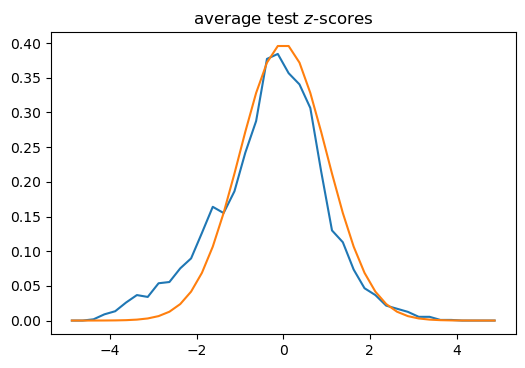

In [18]:
z_hist = np.mean(test_z_hists[6:], axis=0)

plt.figure(dpi=100)
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title("average test $z$-scores")

In [19]:
z_scores = np.array(z_scores)
test_z_scores = np.array(test_z_scores)
losses = np.array(losses)
relative = np.array(relative_perfs)

In [26]:
np.save("experiments\\overconfidence\\" + data_name + "z_scores.npy", z_scores)
np.save("experiments\\overconfidence\\" + data_name + "test_z_scores.npy", test_z_scores)
np.save("experiments\\overconfidence\\" + data_name + "relative_perfs.npy", relative_perfs)
np.save("experiments\\overconfidence\\" + data_name + "losses.npy", losses)

<IPython.core.display.Javascript object>


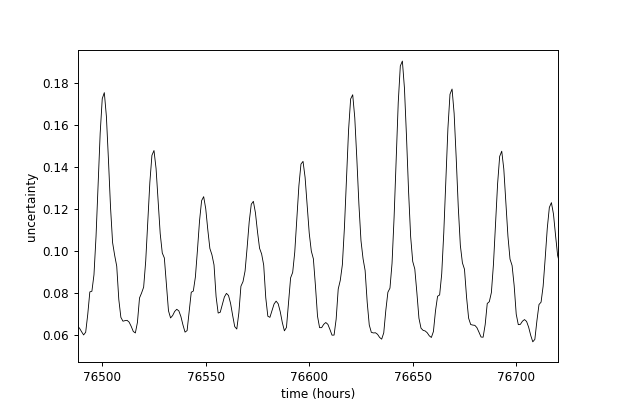

Text(0.5, 0, 'time (hours)')

In [22]:
%matplotlib notebook
std_hat = model.std(params)
plt.plot(std_hat, linewidth=0.7, color="k")
plt.ylabel("uncertainty")
plt.xlabel("time (hours)")

In [21]:
np.mean(a_hat)

-1.1436679

In [30]:
np.save("experiments\\periodic_uncertainty\\" + data_name + "z_scores.npy", z_scores[5])
np.save("experiments\\periodic_uncertainty\\" + data_name + "test_z_scores.npy", test_z_scores[5])
np.save("experiments\\periodic_uncertainty\\" + data_name + "relative_perfs.npy", relative_perfs[5])
np.save("experiments\\periodic_uncertainty\\" + data_name + "losses.npy", losses[5])